In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from collections import Counter
import sys

from utils import nice_tree_plot, niceprint, permute_square, invert_permutation, without_diag
from compute_pam import compute_combo_tensor_pam, IndividualNodeAlphaCalc
from example_graphs import make_tree
from sim_data import PAMSampler, topics_griffiths_steyvers
from lda_collapsed_gibbs import CollapsedGibbs
from tree_extraction import Aho
from tree_extraction.Aho import get_ratio_matrix
from alpha_extract import AlphaExtract
from param_stats import topic_difference, find_flat_permutation, find_structural_permutation

In [2]:
# sys.path.insert(0, '../anchor-word-recovery/')
# from learn_topics import Analysis as AnchorAnalysis

In [3]:
np.random.seed(1)

## Outline

1. Set up parameters of the model (tree structure, alphas, and topic definitions -- anything else?)
2. Compute "true" co-occurrence matrix
3. Generate some simulated data by sampling from the model
  - Parameters: Number of documents, distribution over document sizes
4. Compute "empirical" co-occurrence matrix (using known per-word-slot topic assignments).  Compare to "true" co-occurrence matrix.
5. Apply LDA or anchor words to the simulated data -- estimate topics and co-occurrence matrix.  Compare "estimated" co-occurrence matrix to "true" and "empirical" matrices.  Compare "estimated" topics to "true" topics.
  - Parameters: number of topics; any other parameters needed for the chosen topic-estimation algorithm
6. Compute ratio matrix
7. Derive triplet constraints from ratio matrix
8. Apply Aho's algorithm to constraints, producing a tree where each leaf corresponds to a topic.  Compare to "true" tree structure.
9. Extract alpha parameters from co-occurrence matrix.  Compare to "true" alpha parameters.
  - Parameters: $\alpha_{max}$ and $\delta_{min}$ corresponding to hypothesis class
  
TODO: Find a way to remove # of topics as a parameter (eg, measure perplexity, and loop over different of # topics)

In [4]:
# TODO

# self.aa = AnchorAnalysis(
#     infile = TODO,
#     vocabfile = TODO,
#     outfile = None,
#     loss = "L2",
#     K = num_topics,
#     seed = 100,
#     eps = 1e-6,
#     new_dim = 1000,
#     max_threads = 8,
#     anchor_thresh = 100,
#     top_words = 10,
# )
# self.aa.run()
# return aa.A, aa.R

In [5]:
def make_short_corpus(docs):
    corpus_short = []
    for doc in docs:
        ctr = Counter(doc)
        doc_short = [(k, v) for k, v in ctr.items()]
        corpus_short.append(doc_short)
    return corpus_short

In [6]:
def compute_empirical_cooccur(sampler, leaf_to_index):
    num_topics = len(sampler.topics)
    p = np.zeros((num_topics, num_topics), dtype='float')
    for node_selections in sampler.doc_nodes:
        theta = np.zeros(num_topics, dtype='float')
        counter = Counter(node_selections)
        for node, count in counter.items():
            theta[leaf_to_index[node]] += count
        theta /= theta.sum()
        p += np.outer(theta, theta)
    p /= p.sum()
    return p

In [ ]:
def compute_empirical_topics(sampler, leaf_to_index):
    K = len(sampler.topics)
    V = sampler.vocab_size
    result = np.zeros((K, V), dtype='float')
    # TODO pick up here
    return result

In [7]:
def make_alpha_func(g, alpha_dict):
    child_mapper = {n: [np.array(alpha_dict[c]) for c in g.neighbors(n)]
                    for n in g.nodes() if g.out_degree(n) > 0}
    def f(node):
        return child_mapper[node]
    return f

In [8]:
def make_topic_func(true_topics, leaf_to_index):
    def topic_func(node):
        return true_topics[leaf_to_index[node], :]
    return topic_func

In [9]:
class Analysis(object):
    def __init__(
            self,
            # Data generation params:
            true_tree,
            true_alphas,
            num_docs,
            words_per_doc,
            vocab_size,
            true_topics,
            leaf_to_index,
            # Extraction params:
            num_topics_to_train,
            delta_min,
            alpha_max,
            topic_extraction_strategy,
            topic_extraction_params):

        self.true_tree = true_tree
        self.true_alphas = true_alphas
        self.num_docs = num_docs
        self.words_per_doc = words_per_doc
        self.vocab_size = vocab_size
        self.true_topics = true_topics
        self.leaf_to_index = leaf_to_index
        self.num_topics_to_train = num_topics_to_train
        self.delta_min = delta_min
        self.alpha_max = alpha_max
        self.topic_extraction_strategy = topic_extraction_strategy
        self.topic_extraction_params = topic_extraction_params

        self.true_num_topics = true_topics.shape[0]
        self.threshold = self.delta_min / ((1 + self.alpha_max) * (1 + self.alpha_max + self.delta_min))
    
    def run(self):
        self.alpha_calc = IndividualNodeAlphaCalc(tree = self.true_tree, values = self.true_alphas)
        self.true_cooccur = compute_combo_tensor_pam(g = self.true_tree, alpha = self.alpha_calc)
        
        # Generate data
        self.sampler = PAMSampler(
            g = self.true_tree,
            num_docs = self.num_docs,
            words_per_doc = self.words_per_doc,
            vocab_size = self.vocab_size,
            alpha_func = make_alpha_func(self.true_tree, self.true_alphas),
            topic_func = make_topic_func(self.true_topics, self.leaf_to_index),
        )
        self.sampler.sample()
        self.corpus = make_short_corpus(self.sampler.docs)

        # Compute empirical statistics from topic-labeled data
        self.emp_cooccur = compute_empirical_cooccur(sampler = self.sampler, leaf_to_index = self.leaf_to_index)
        # TODO: self.emp_topics = compute_empirical_topics(...)
        
        # Extract topics and co-occurrence from data
        # TODO: allow switching between collapsed gibbs & anchor words
        if self.topic_extraction_strategy = "CollapsedGibbs":
            kwargs = dict()
            kwargs.update(self.topic_extraction_params)
            kwargs.update(dict(
                corpus = self.corpus,
                num_topics = self.num_topics_to_train,
                vocab_size = self.vocab_size,
            ))
            self.collapsed_gibbs_kwargs = kwargs

            self.collapsed_gibbs = CollapsedGibbs()
            self.collapsed_gibbs.fit(**kwargs)

            self.est_topics = self.collapsed_gibbs.topics_by_sample()[-1]  # TODO: revisit this calculation?
            self.est_cooccur = self.collapsed_gibbs.cooccurrence_by_sample()[-1]  # TODO: revisit this calculation?

        else:
            raise ValueError("Unrecognized strategy: '{}'".format(topic_extraction_strategy))
        
        # Extract tree & other parameters from data
        self.est_results = self.cooccur_to_tree_and_alphas(self.est_cooccur, self.threshold)
        self.emp_results = self.cooccur_to_tree_and_alphas(self.emp_coooccur, self.threshold)
        self.true_c_results = self.cooccur_to_tree_and_alphas(self.true_cooccur, self.threshold)
        
        self.est_alphas, self.est_tree = [self.est_results[x] for x in ["alphas", "tree"]]
        self.emp_alphas, self.emp_tree = [self.emp_results[x] for x in ["alphas", "tree"]]
        self.true_c_alphas, self.true_c_tree = [self.true_c_results[x] for x in ["alphas", "tree"]]
        
        return self.est_topics, self.est_tree, self.est_alphas
        
    def cooccur_to_tree_and_alphas(self, cooccur, threshold):
        result = dict()

        result["ratio_matrix"] = get_ratio_matrix(cooccur)
        result["constraints"] = Aho.get_constraints(result["ratio_matrix"], threshold = threshold)
        result["tree"] = Aho.extract(m = result["ratio_matrix"], apply_ratio = False, threshold = threshold)
        result["alpha_extract"] = AlphaExtract(g = result["tree"], R = cooccur)
        result["alphas"] = result["alpha_extract"].extract()
        
        return result

In [10]:
branching_factors = [2, 2, 2]
num_true_topics = np.prod(branching_factors)  # number of topics with which to generate data

true_tree = make_tree(branching_factors)
index_to_leaf = [x for x in true_tree.nodes() if true_tree.out_degree(x) == 0]
leaf_to_index = {leaf: idx for idx, leaf in enumerate(index_to_leaf)}

In [11]:
# N = 10  # number of documents to generate
# M = 20  # number of words per document
# V = 25  # number of words in vocabulary
# dim = 5  # size of "square" to use in defining topics
# assert dim ** 2 == V

In [12]:
N = 1000  # number of documents to generate
M = 200  # number of words per document
V = 100  # number of words in vocabulary
dim = 10  # size of "square" to use in defining topics
assert dim ** 2 == V

In [13]:
true_topics = topics_griffiths_steyvers(num_topics = num_true_topics, dimension = dim)

In [14]:
true_alphas = {
    1: 1.5,
    2: 1.7,
    3: 1.9,
    4: 1.8,
    5: 2.0,
    6: 1.7,
    7: 1.6,
    8: 1.7,
    9: 1.8,
    10: 1.9,
    11: 1.4,
    12: 1.7,
    13: 1.5,
    14: 1.6,
}

In [15]:
# Main user-selected parameters for training & extraction
num_topics_to_train = num_true_topics
delta_min = 0.1
alpha_max = 10.0
custom_prior = 1.3 ** np.arange(len(index_to_leaf))[::-1]

In [ ]:
topic_extraction_strategy = "CollapsedGibbs"
topic_extraction_params = dict(alpha = custom_prior)

In [16]:
a = Analysis(
    # Data generation params:
    true_tree = true_tree,
    true_alphas = true_alphas,
    num_docs = N,
    words_per_doc = M,
    vocab_size = V,
    true_topics = true_topics,
    leaf_to_index = leaf_to_index,
    # Extraction params:
    num_topics_to_train = num_topics_to_train,
    delta_min = delta_min,
    alpha_max = alpha_max,
    topic_extraction_strategy = topic_extraction_strategy,
    topic_extraction_params = topic_extraction_params,
)

In [17]:
a.run();

Training: 100%|█████████▉| 2010/2010 [7:32:17<00:00, 13.50s/it]     


## Display results

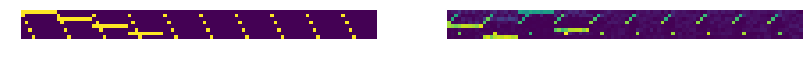

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(a.true_topics)
ax[0].axis('off')
ax[1].imshow(a.est_topics)
ax[1].axis('off')
None

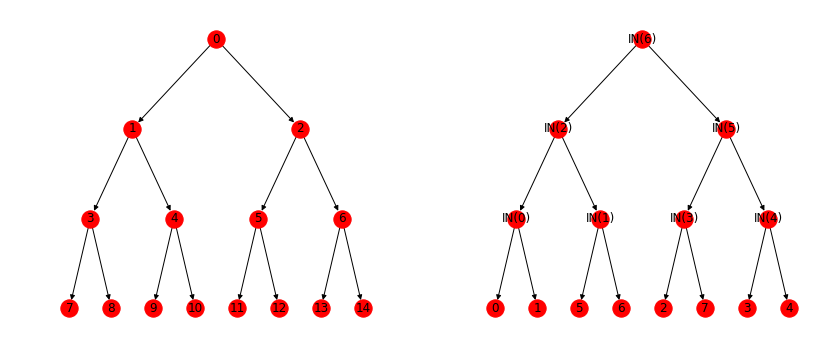

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
nice_tree_plot(a.true_tree, ax[0])
nice_tree_plot(a.est_tree, ax[1])

In [20]:
print(a.true_alphas)
print(a.est_alphas)

{1: 1.5, 2: 1.7, 3: 1.9, 4: 1.8, 5: 2.0, 6: 1.7, 7: 1.6, 8: 1.7, 9: 1.8, 10: 1.9, 11: 1.4, 12: 1.7, 13: 1.5, 14: 1.6}
{IN(2): 4.893333288340806, IN(0): 3.477597163901028, 0: 3.4779748234205576, 1: 2.8389699406939926, IN(1): 2.583706491515549, 5: 1.6376986957767417, 6: 1.366583834052095, IN(5): 2.6597074425729113, IN(3): 1.9349919304537067, 2: 1.0439312844898097, 7: 0.6898293521041491, IN(4): 1.4407683722413303, 3: 0.6023147488693826, 4: 0.6996963410277293}


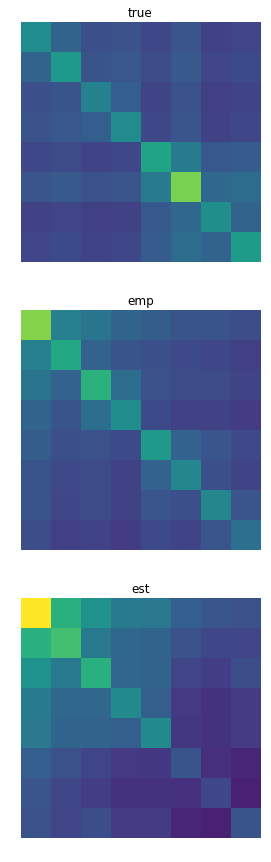

In [21]:
# Plot cooccurrence matrices
specs = [
    dict(name='true', cooccur=a.true_cooccur),
    dict(name='emp', cooccur=a.emp_cooccur),
    dict(name='est', cooccur=a.est_cooccur),
]

vmin=0.0
vmax=np.max([np.max(s["cooccur"]) for s in specs])

fig, ax = plt.subplots(len(specs), 1, figsize=(5, 5*len(specs)))
for i, spec in enumerate(specs):
    ax[i].imshow(spec["cooccur"], vmin=vmin, vmax=vmax)
    ax[i].axis('off')
    ax[i].set_title(spec["name"])

## Save results

In [22]:
import datetime
import pickle

In [23]:
def save_results(a, filename):
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_at_%H-%M-%S')
    filename = filename.replace('.pkl', '_' + timestamp + '.pkl')
    print("Saving to {}".format(filename))
    obj = {
        'timestamp': timestamp,
        'true_tree_leaf_to_index': a.leaf_to_index,
        'corpus': a.corpus,
        'true_num_topics': len(a.sampler.topics),
        'est_num_topics': a.est_topics.shape[0],
        'true_topics': a.true_topics,
        'est_topics': a.est_topics,
        'true_tree': a.true_tree,
        'est_tree': a.est_tree,
        'true_cooccur': a.true_cooccur,
        'emp_cooccur': a.emp_cooccur,
        'est_cooccur': a.est_cooccur,
        'true_alphas': a.true_alphas,
        'est_alphas': a.est_alphas,
    }
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

In [24]:
save_results(a, 'results/results.pkl')

Saving to results/results_2019-05-07_at_07-59-54.pkl


## Find permutation that maps estimated topics to true topics

In [25]:
perm = find_flat_permutation(true_topics=a.true_topics, est_topics=a.est_topics)
perm

array([4, 3, 7, 2, 0, 1, 5, 6])

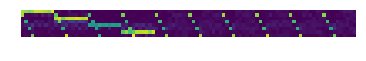

In [26]:
fig, ax = plt.subplots()
ax.imshow(a.est_topics[perm, :])
ax.axis('off')
None

In [27]:
est_cooccur_permuted = permute_square(X = a.est_cooccur, perm = perm)

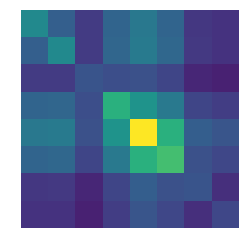

In [28]:
fig, ax = plt.subplots()
ax.imshow(est_cooccur_permuted, vmin=vmin, vmax=vmax)
ax.axis('off')
None

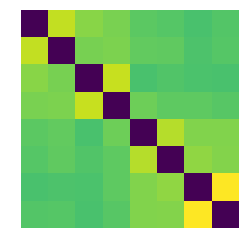

In [29]:
est_ratio_permuted = get_ratio_matrix(est_cooccur_permuted)

fig, ax = plt.subplots()
ax.imshow(without_diag(est_ratio_permuted))
ax.axis('off')
None

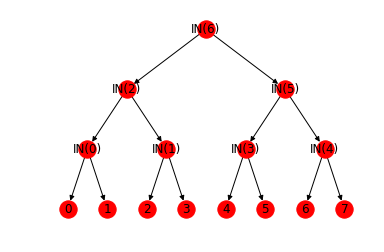

In [30]:
nice_tree_plot(Aho.extract(est_ratio_permuted, apply_ratio=False))

## Compare results of alpha extraction

In [40]:
# TODO: repeat with emp_tree, emp_alphas, emp_cooccur

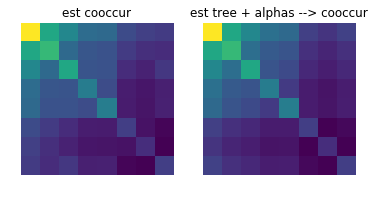

In [34]:
zzz = compute_combo_tensor_pam(a.est_tree, alpha=IndividualNodeAlphaCalc(a.est_tree, a.est_alphas))

fig, ax = plt.subplots(1, 2)

ax[0].imshow(a.est_cooccur)
ax[0].axis('off')
ax[0].set_title('est cooccur')

ax[1].imshow(zzz)
ax[1].axis('off')
ax[1].set_title('est tree + alphas --> cooccur')

None

In [35]:
np.max(np.abs(zzz - a.est_cooccur))

0.002602196403142727

In [57]:
to_prune = [
    ["sampler", "topic_func"],
    ["sampler", "alpha_func"],
    ["collapsed_gibbs"],
]
pruned = dict()
pruned_string = "PRUNED FOR SERIALIZATION"
for path in to_prune:
    prev = None
    curr = a
    missing = False
    for p in path:
        prev = curr
        if not hasattr(curr, p) or getattr(curr, p) == pruned_string:
            missing = True
            break
        curr = getattr(curr, p)
    if not missing:
        setattr(prev, path[-1], pruned_string)
        pruned[tuple(path)] = curr
pruned

{}

In [56]:
with open('temp_a.pkl', 'wb') as f:
    pickle.dump(a, f)